# TensorFlow.ipynb

In [1]:
print("Hello World")

Hello World


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [3]:

url_premier_league = ["https://www.football-data.co.uk/mmz4281/2021/E0.csv",
"https://www.football-data.co.uk/mmz4281/1920/E0.csv",
"https://www.football-data.co.uk/mmz4281/1819/E0.csv",
"https://www.football-data.co.uk/mmz4281/1718/E0.csv",
"https://www.football-data.co.uk/mmz4281/1617/E0.csv",
"https://www.football-data.co.uk/mmz4281/1516/E0.csv"]

In [83]:
li = []
for url in url_premier_league:
    df = pd.read_csv(filepath_or_buffer=url)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [93]:
frame_select = frame[["HomeTeam","AwayTeam","Date","HTHG","HTAG","FTHG","FTAG","FTR"]]
frame_select = frame_select.dropna()

,HomeTeam,AwayTeam,Date,HTHG,HTAG,FTHG,FTAG,FTR
0,Fulham,Arsenal,12/09/2020,0,1,0,3,A
1,Crystal Palace,Southampton,12/09/2020,1,0,1,0,H
2,Liverpool,Leeds,12/09/2020,3,2,4,3,H
3,West Ham,Newcastle,12/09/2020,0,0,0,2,A
4,West Brom,Leicester,13/09/2020,0,0,0,3,A
...,...,...,...,...,...,...,...,...
2074,Stoke,West Ham,15/05/16,0,1,2,1,H
2075,Swansea,Man City,15/05/16,1,1,1,1,D
2076,Watford,Sunderland,15/05/16,0,1,2,2,D
2077,West Brom,Liverpool,15/05/16,1,1,1,1,D


In [73]:
frame_select.head()

X = frame_select[["HTHG","HTAG"]]

y_FTR_Home = frame_select[["FTR"]]=="H"
X_train_FTR_Home, X_test_FTR_Home, y_train_FTR_Home, y_test_FTR_Home = train_test_split( X, y_FTR_Home, test_size=0.3, random_state=1, stratify=y_FTR_Home)

y_FTR_Draw = frame_select[["FTR"]]=="D"
X_train_FTR_Draw, X_test_FTR_Draw, y_train_FTR_Draw, y_test_FTR_Draw = train_test_split( X, y_FTR_Draw, test_size=0.3, random_state=1, stratify=y_FTR_Draw)

y_FTR_Away = frame_select[["FTR"]]=="A"
X_train_FTR_Away, X_test_FTR_Away, y_train_FTR_Away, y_test_FTR_Away = train_test_split( X, y_FTR_Away, test_size=0.3, random_state=1, stratify=y_FTR_Away)


In [12]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [18]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_FTR_Home, y_train_FTR_Home)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [19]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [20]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                       n_estimators=1600)

In [22]:
rf_random_fit = rf_random.best_estimator_.fit(X_train_FTR_Home,y_train_FTR_Home)

In [38]:
predicted = rf_random_fit.predict_proba(X = X_test_FTR_Home)[:,0]

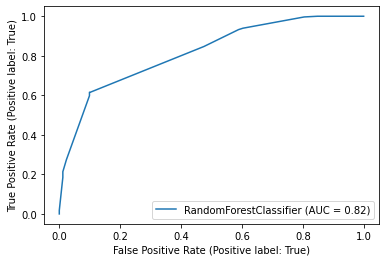

In [40]:
metrics.roc_auc_score(y_true=y_test_FTR_Home,y_score=predicted)
metrics.plot_roc_curve(rf_random_fit,X_test_FTR_Home,y_test_FTR_Home)

# TensorFlow

In [74]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [154]:
encoder = LabelEncoder()
X = X_train_FTR_Home.astype(float)
Y = y_train_FTR_Home.FTR
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

In [155]:
encoder = LabelEncoder()
X_test = X_test_FTR_Home.astype(float)
Y_test = y_test_FTR_Home.FTR
encoder.fit(Y_test)
encoded_Y_test = encoder.transform(Y_test)

In [161]:
# baseline model
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(2, input_dim=2, activation='relu'))
	model.add(Dense(30, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [162]:
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)

In [163]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)

In [164]:
results = cross_val_score(estimator, X.values, encoded_Y, cv=kfold)
results

array([0.73287672, 0.71232879, 0.75342464, 0.80136985, 0.76027399,
       0.7241379 , 0.73793101, 0.80000001, 0.7034483 , 0.80689657])

In [168]:
estimator.fit(X_train_FTR_Home,encoded_Y)

In [169]:
predicted_probs = estimator.predict_proba(X_test_FTR_Home)[:,1]

In [170]:
metrics.roc_auc_score(y_true = encoded_Y_test,y_score = predicted_probs)

0.8186869053671291